The quality of our numerical estimate depends on two key approximations
*   Integral truncation: The infinite Fourier integral in is approximated by a finite integral from $-U$ to $U$. The accuracy of this step depends on the cutoff $U$.
*   Discretisation: The finite integral is then approximated by a Riemann sum, which is computed via the FFT. The accuracy of this step depends on the resolution of the grid.

The parameters $N$ and $X$ control these factors as follows. Through $U = N\Delta u / 2 = N / (4X)$, a larger $U$ means we are truncating less of the integral, leading to a more accurate approximation. The distance between points on our grid is $\Delta x = 2X / N$. A smaller $\Delta x$ gives a finer, more detailed approximation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# (We reuse the A(u, y) function from the previous answer)
def A(u, y, n):
    term_sin_over_u = n * np.pi * np.sinc(n * u)
    a_val = np.zeros_like(u, dtype=complex)
    mask_le_1 = np.abs(u) <= 1
    mask_gt_1 = np.abs(u) > 1
    u1 = u[mask_le_1]
    a_val[mask_le_1] = term_sin_over_u[mask_le_1] * np.exp(2j * np.pi * y * np.sqrt(1 - u1**2))
    u2 = u[mask_gt_1]
    a_val[mask_gt_1] = term_sin_over_u[mask_gt_1] * np.exp(-2 * np.pi * np.abs(y) * np.sqrt(u2**2 - 1))
    return a_val

def compute_hx(n, y, N, X):
    dx = 2 * X / N
    du = 1 / (2 * X)
    u_values = np.fft.fftfreq(N, d=dx)
    A_values = A(u_values, y, n)
    h_hat_approx = np.fft.ifft(A_values)
    scaling_factor = (du / (2 * np.pi)) * N
    hx_unshiffed = scaling_factor * h_hat_approx
    hx_estimate = np.fft.fftshift(hx_unshiffed)
    x_coords = np.linspace(-X, X, num=N, endpoint=False)
    return x_coords, hx_estimate

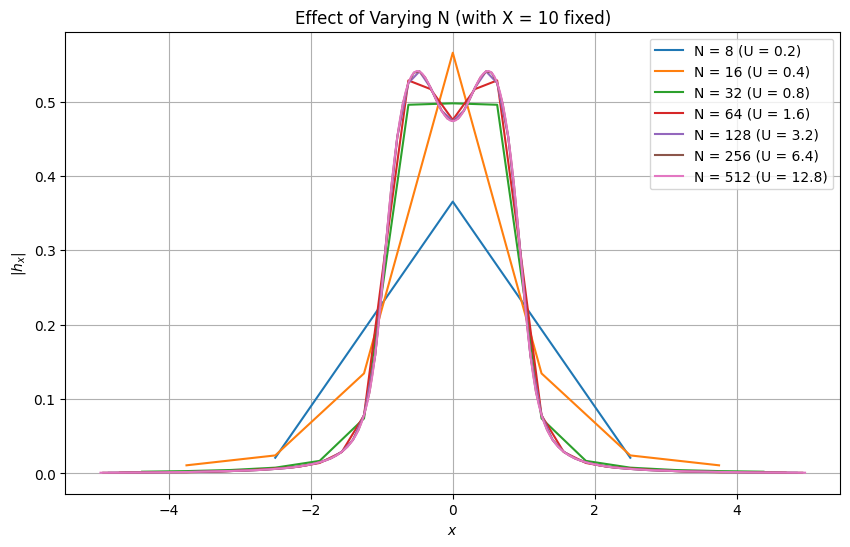

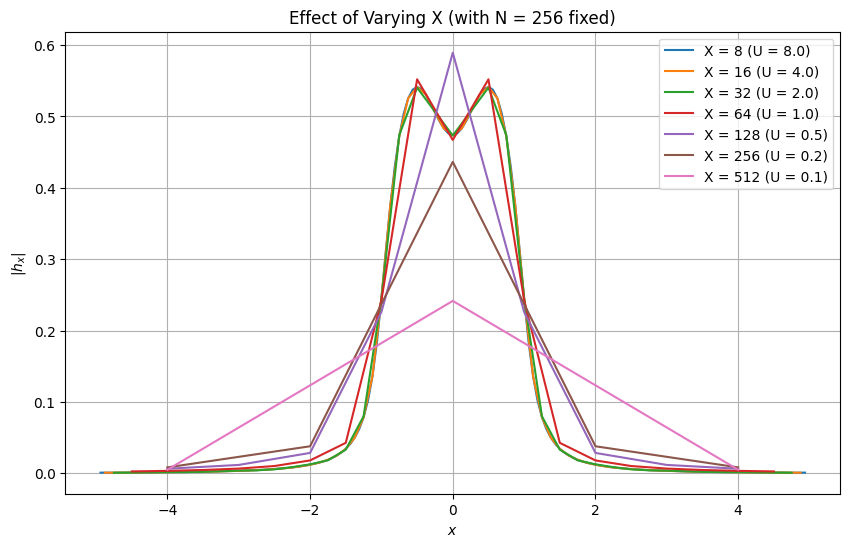

In [2]:
# Effect of varying N
n_val, y_val = 2, 0.2
X_fixed = 10
N_values = [2**i for i in range(3, 10)]

plt.figure(figsize=(10, 6))
for N_val in N_values:
    x, hx = compute_hx(n_val, y_val, N_val, X_fixed)
    # We only plot for |x| < 5
    mask = np.abs(x) < 5
    plt.plot(x[mask], np.abs(hx[mask]), label=f'N = {N_val} (U = {N_val/(4*X_fixed):.1f})')

plt.title(f'Effect of Varying N (with X = {X_fixed} fixed)')
plt.xlabel('$x$')
plt.ylabel('$|h_x|$')
plt.legend()
plt.grid(True)
plt.show()

# Effect of varying X
N_fixed = 256
X_values = [2**i for i in range(3, 10)]

plt.figure(figsize=(10, 6))
for X_val in X_values:
    x, hx = compute_hx(n_val, y_val, N_fixed, X_val)
    mask = np.abs(x) < 5
    plt.plot(x[mask], np.abs(hx[mask]), label=f'X = {X_val} (U = {N_fixed/(4*X_val):.1f})')

plt.title(f'Effect of Varying X (with N = {N_fixed} fixed)')
plt.xlabel('$x$')
plt.ylabel('$|h_x|$')
plt.legend()
plt.grid(True)
plt.show()

For a fixed domain $X$, increasing $N$ improves the estimate by increasing both the spatial resolution ($\Delta x$ gets smaller) and the accuracy of the integral approximation ($U$ gets larger). The solution converges as $N$ grows.

For a fixed number of points $N$, increasing the domain $X$ is harmful to the estimate. It simultaneously worsens the spatial resolution ($\Delta x$ gets larger) and reduces the accuracy of the integral approximation ($U$ gets smaller).

The function $A(u, y)$ in the frequency domain becomes more concentrated around $u=0$ as $y$ increases primarily due to the rapid exponential decay for $|u| > 1$. A Fourier transform property states that if a function is narrow in one domain ($u$-space), then its transform is broad in the other domain ($x$-space). Therefore, for larger $y$, $h_x(x,y)$ is expected to be more spread out in $x$.

To capture this spread and avoid artificial truncation (aliasing), we need a larger spatial domain $X$. We also need to ensure the frequency cutoff $U = N/(4X)$ is sufficiently large (greater than $1$) to sample the critical region $|u| \leq 1$ where $A(u,y)$ is most active.


*   As $y$ gets smaller, $h_x(x,y)$ tends to become more oscillatory in $x$ as it approaches $j_0(t)$ related functions, which oscillate. To accurately capture these rapid oscillations, a very fine spatial resolution (small $\Delta x$) is required. If $h_x$ oscillates even faster, this $\Delta x$ might be too large to prevent aliasing in the $x$-domain. Therefore, for very small $y$ values, a larger $N$ would be more appropriate to achieve a higher spatial resolution.

*   For larger $y$, $h_x(x,y)$ becomes very spread out and smooth in the $x$-domain. While this smoothness might suggest a lower $\Delta x$ is acceptable, the function $A(u,y)$ in the frequency domain becomes highly oscillatory for $|u| \leq 1$ due to the exponential term. To resolve these rapid oscillations in within the sampled frequency domain $[-U, U]$, a larger $N$ is required to prevent aliasing in the $x$-domain.

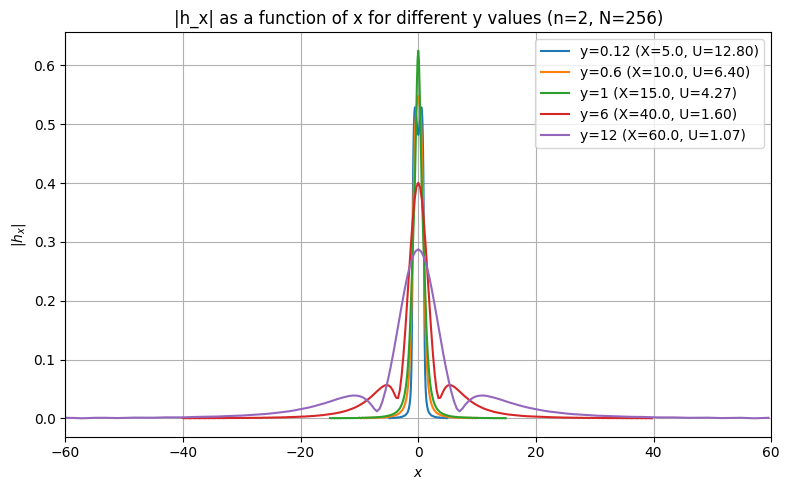

In [3]:
# Parameters
n_val = 2
N_val = 256 # Fixed N
y_values = [0.12, 0.6, 1, 6, 12]
X_values_for_y = {
    0.12: 5.0,  # U = 256/(4*5) = 12.8. Smallest y, h_x is somewhat localised or oscillatory.
    0.6: 10.0, # U = 256/(4*10) = 6.4.
    1: 15.0,   # U = 256/(4*15) = 4.27.
    6: 40.0,   # U = 256/(4*40) = 1.6. Larger y, h_x is more spread out.
    12: 60.0,  # U = 256/(4*60) = 1.06. Very large y, h_x is significantly spread. U is still > 1.
}

# Single graph of |h_x| for different `y` values

plt.figure(figsize=(8, 5))

for y_val in y_values:
    X_val = X_values_for_y[y_val]
    x_coords, hx_estimate = compute_hx(n_val, y_val, N_val, X_val)
    hx_modulus = np.abs(hx_estimate)

    plt.plot(x_coords, hx_modulus, label=f'y={y_val} (X={X_val}, U={N_val/(4*X_val):.2f})')

plt.title(f'|h_x| as a function of x for different y values (n={n_val}, N={N_val})')
plt.xlabel('$x$')
plt.ylabel('$|h_x|$')
plt.xlim([-max(X_values_for_y.values()), max(X_values_for_y.values())]) # Set x-lim to the largest X
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

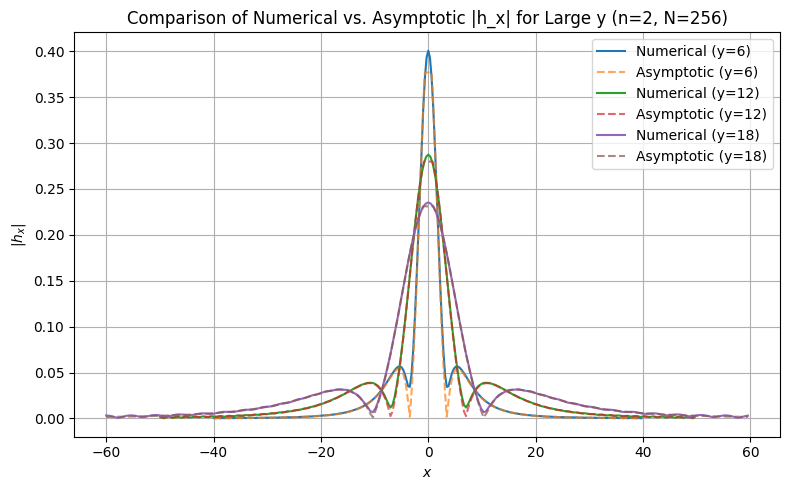

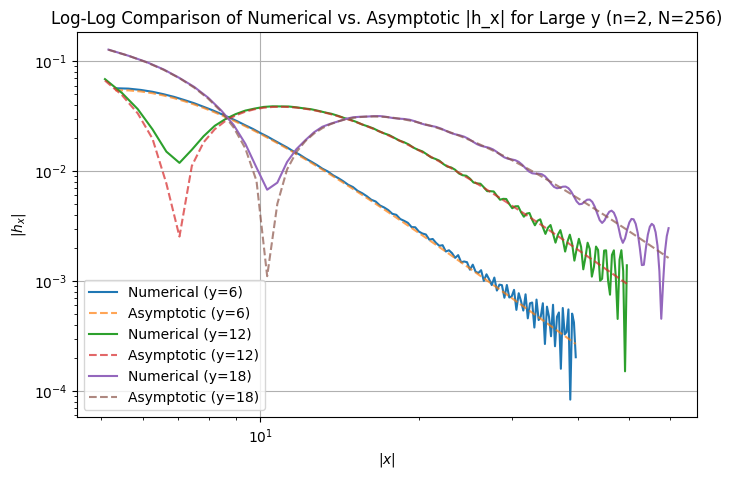

In [4]:
def hx_asymptotic(x_coords, y, n):
    '''
    Computes the asymptotic formula for |h_x|:
    |h_x| ~ (n / (2 * sqrt(x^2 + y^2))) * (|y| / |x|)
    '''
    hx_asy = np.zeros_like(x_coords, dtype=float)
    # Mask non-zero x to work with
    mask = np.abs(x_coords) > 1e-9
    x = x_coords[mask]

    v = x / np.sqrt(x**2 + y**2)

    # Numerator term
    numerator = np.sin(n * np.pi * v)
    # Denominator term
    denominator = 2 * np.pi * v
    # Root term
    sqrt_arg = np.sqrt(v * (1 - v**2) / x)

    # The limit of the expression is 0 as x -> 0.
    hx_asy[mask] = np.abs(numerator / denominator) * sqrt_arg

    return hx_asy

# Comparison with Asymptotic Formula
y_comp_values = [6, 12, 18]
X_comp_values = {
    6: 40.0,
    12: 50.0,
    18: 60.0
}

plt.figure(figsize=(8, 5))

for y_val in y_comp_values:
    X_val = X_comp_values[y_val]
    x_coords, hx_estimate = compute_hx(n_val, y_val, N_val, X_val)
    hx_modulus = np.abs(hx_estimate)

    # Plot numerical estimate
    plt.plot(x_coords, hx_modulus, label=f'Numerical (y={y_val})', linestyle='-')

    # Plot asymptotic formula
    # Filter x_coords to avoid singularity at x=0 for the asymptotic formula
    x_for_asymptotic = x_coords[np.abs(x_coords) > 0.5]
    hx_asy_val = hx_asymptotic(x_for_asymptotic, y_val, n_val)
    plt.plot(x_for_asymptotic, hx_asy_val, label=f'Asymptotic (y={y_val})', linestyle='--', alpha=0.7)

plt.title(f'Comparison of Numerical vs. Asymptotic |h_x| for Large y (n={n_val}, N={N_val})')
plt.xlabel('$x$')
plt.ylabel('$|h_x|$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Log-Log plot for observing power-law decay
plt.figure(figsize=(8, 5))
for y_val in y_comp_values:
    X_val = X_comp_values[y_val]
    x_coords, hx_estimate = compute_hx(n_val, y_val, N_val, X_val)
    hx_modulus = np.abs(hx_estimate)

    # Filter x_coords to positive values away from 0
    mask_positive_x = x_coords > 5.0
    x_pos = x_coords[mask_positive_x]
    hx_mod_pos = hx_modulus[mask_positive_x]

    # Plot numerical estimate
    plt.loglog(x_pos, hx_mod_pos, label=f'Numerical (y={y_val})', linestyle='-')

    # Plot asymptotic formula
    hx_asy_val_pos = hx_asymptotic(x_pos, y_val, n_val)
    plt.loglog(x_pos, hx_asy_val_pos, label=f'Asymptotic (y={y_val})', linestyle='--', alpha=0.7)

plt.title(f'Log-Log Comparison of Numerical vs. Asymptotic |h_x| for Large y (n={n_val}, N={N_val})')
plt.xlabel('$|x|$')
plt.ylabel('$|h_x|$')
plt.legend()
plt.grid(True, ls="-")
plt.show()

The asymptotic formula predicts a singularity at $x=0$ due to the $|y|/|x|$ term. This causes the asymptotic curves to shoot up towards infinity as $x \to 0$. In contrast, the numerical estimates for $|h_x|$ are smooth and have a finite, rounded peak at $x=0$ for all $y$ values. This indicates that the asymptotic formula is a poor approximation in the immediate vicinity of $x=0$.

As $y$ increases, the region of agreement between the numerical and asymptotic results generally widens and the match becomes closer. Thus, the asymptotic formula provides a reasonable approximation for the numerical results only for large $y$ and for $|x|$ values that are sufficiently far from $0$.

For $|x|$ values sufficiently far from $0$ (typically $|x| > y$), the asymptotic formula simplifies to $|h_x| \approx n|y| / (2x^2)$, indicating a $1/x^2$ power-law decay.

---

We perform a similar analysis for $n = 3$ and $n = 4$. The parameter $n$ controls the frequency of the $\sin(n\pi u)$ term within the function $A(u, y)$. As $n$ increases, this term oscillates more rapidly in the frequency $u$-domain. To accurately capture these faster oscillations and avoid aliasing, a higher sampling rate $N$ is necessary.

Furthermore, the parameter $n$ relates to the physical width of the current-carrying strip $d = n\pi/2$. A larger $n$ corresponds to a wider source which generates a magnetic field $h_x$ that is more spread out in the spatial $x$-domain. To capture this broader field without introducing artificial boundary effects, we must choose larger values of $X$, dependent on $y$.

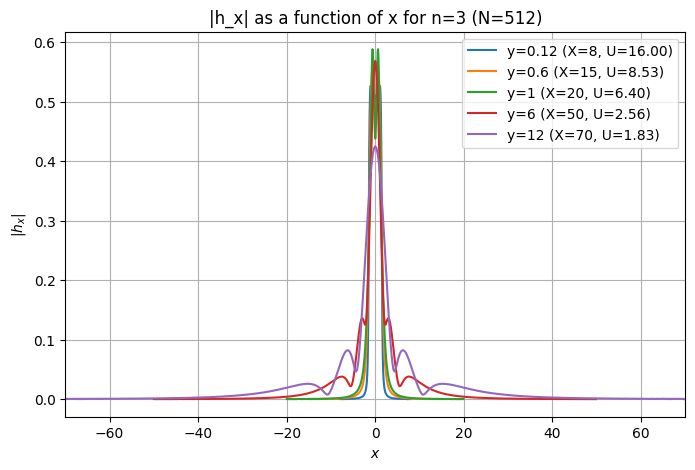

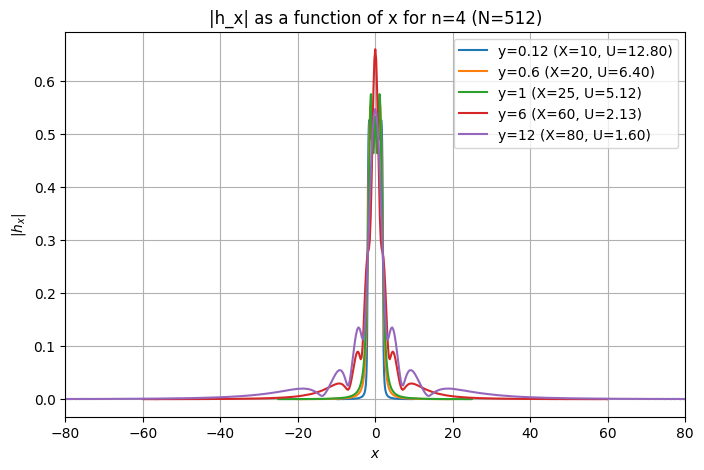

In [7]:
n_values = [3, 4]
N_val = 512  # Increased N for higher n
y_values = [0.12, 0.6, 1, 6, 12]

X_choices_n3 = {0.12: 8, 0.6: 15, 1: 20, 6: 50, 12: 70}
X_choices_n4 = {0.12: 10, 0.6: 20, 1: 25, 6: 60, 12: 80}
X_map = {3: X_choices_n3, 4: X_choices_n4}

for n_val in n_values:
    plt.figure(figsize=(8, 5))
    X_choices = X_map[n_val]
    for y_val in y_values:
        X_val = X_choices[y_val]
        x_coords, hx_estimate = compute_hx(n_val, y_val, N_val, X_val)

        plt.plot(x_coords, np.abs(hx_estimate),
                 label=f'y={y_val} (X={X_val}, U={N_val/(4*X_val):.2f})')

    plt.title(f'|h_x| as a function of x for n={n_val} (N={N_val})')
    plt.xlabel('$x$')
    plt.ylabel('$|h_x|$')
    plt.xlim([-max(X_choices.values()), max(X_choices.values())])
    plt.legend()
    plt.grid(True)
    plt.show()

As $n$ increases, the overall magnitude of the magnetic field $|h_x|$ also increases, and the field becomes more spread out along the $x$-axis, confirming our reasoning for choosing larger $X$ values.

The numerical method approximates the true field $h$ with a computed estimate $\hat{h}$. The quality of this approximation depends on the relationship between the physical parameters $(n, y)$ and the numerical parameters $(N, X)$.

*   The parameter $n$ defines the width of the current source. A larger $n$ creates a wider source, which generally produces a stronger, more spatially extended magnetic field. The function $A(u, y)$ contains the term $\sin(n\pi u)$. As $n$ increases, this function oscillates more rapidly in the frequency $u$-domain. To accurately compute the Fourier integral via a discrete sum (FFT), the sampling must be fine enough to resolve these oscillations. If $N$ is too small for a given $n$, then the numerical integration will be inaccurate, leading to a poor approximation $\hat{h}$.

*   The parameter $y$ is the vertical distance from the source. It dictates two distinct physical regimes. When $y$ is very small, we are observing the field very close to the source. This "near-field" can contain very fine spatial details and rapid oscillations in $x$. To resolve these features, the spatial step $\Delta x = 2X/N$ must be very small. This requires a large $N$ for a given $X$. When $y$ is large, the field $h(x, y)$ becomes smooth and spread out in $x$. The term $\exp(2\pi iy\sqrt{1-u^2})$ inside $A(u, y)$ becomes highly oscillatory for $|u| < 1$. If $N$ is not large enough to provide sufficient sample points $u_k$ to resolve these oscillations, then the resulting approximation $\hat{h}$ will be incorrect due to aliasing.


The parameters $X$ and $N$, which we control, define the spatial resolution $\Delta x = 2X/N$ and the frequency cutoff $U = N/(4X)$. For a fixed number of points $N$, there is a direct trade-off. Increasing $X$ to capture a more spread-out field comes at the cost of decreasing the frequency cutoff $U$ and increasing $\Delta x$. The challenges posed by large $n$, large $y$ (fast oscillations in the u-domain) and small $y$ (fast oscillations in the x-domain) all translate to a requirement for a sufficiently large $N$. If $N$ is too small, then no choice of $X$ can produce an accurate result. $X$ must then be chosen to balance the physical extent of the field against the need to keep the frequency cutoff $U$ reasonably large. Ideally, $U$ should be large enough that $A(u,y)$ has decayed to negligible values for $|u| > U$.

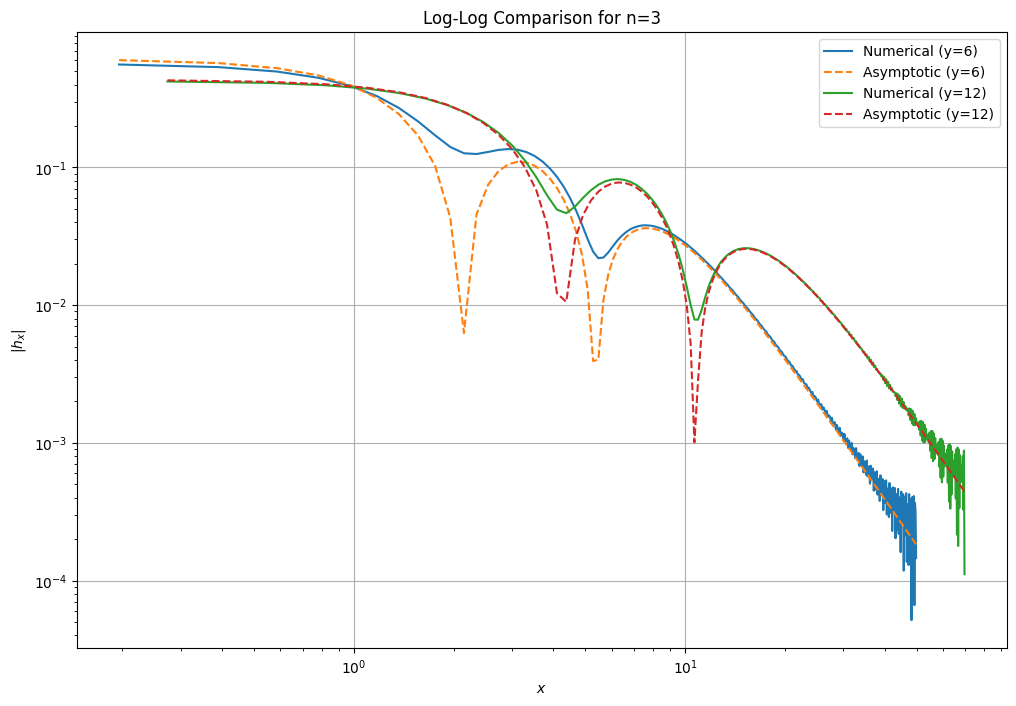

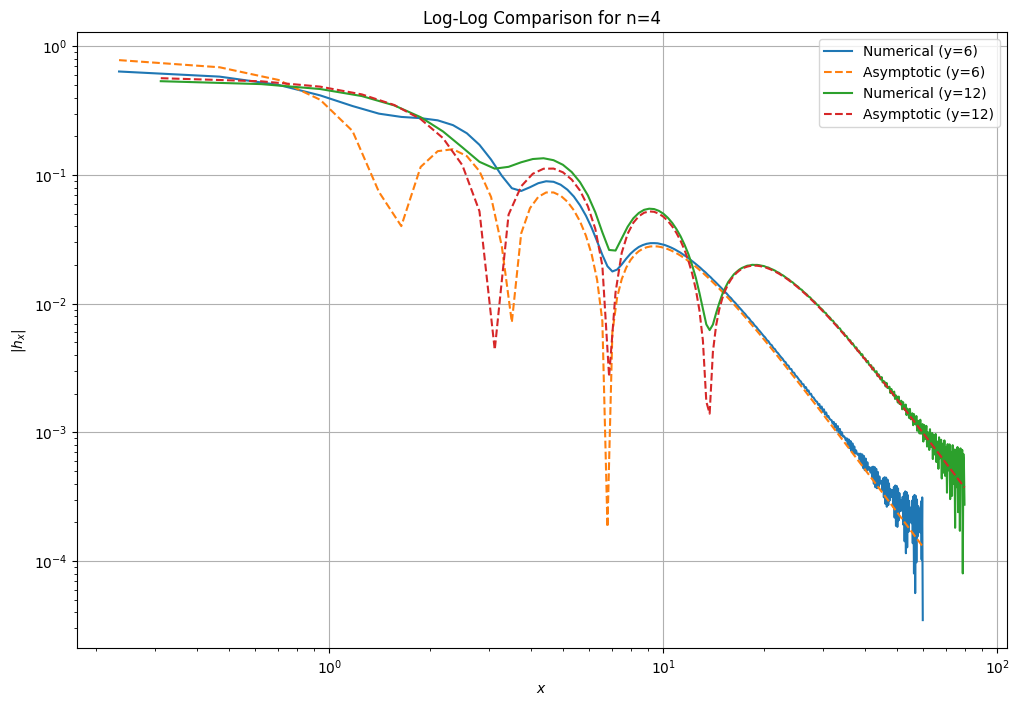

In [9]:
# Log-Log plot for n=3
n_val = 3
N_val = 512
y_comp_values = [6, 12]
X_comp_choices_n3 = {6: 50, 12: 70}
plt.figure(figsize=(12, 8))
for y_val in y_comp_values:
    X_val = X_comp_choices_n3[y_val]
    x_coords, hx_num = compute_hx(n_val, y_val, N_val, X_val)
    hx_asy = hx_asymptotic(x_coords, y_val, n_val)
    # Filter for positive x for log plot
    mask_pos = x_coords > 0.1
    plt.loglog(x_coords[mask_pos], np.abs(hx_num[mask_pos]), label=f'Numerical (y={y_val})')
    plt.loglog(x_coords[mask_pos], hx_asy[mask_pos], label=f'Asymptotic (y={y_val})', linestyle='--')
plt.title(f'Log-Log Comparison for n={n_val}')
plt.xlabel('$x$')
plt.ylabel('$|h_x|$')
plt.legend()
plt.grid(True)
plt.show()

# Log-Log plot for n=4
n_val = 4
N_val = 512
y_comp_values = [6, 12]
X_comp_choices_n4 = {6: 60, 12: 80}
plt.figure(figsize=(12, 8))
for y_val in y_comp_values:
    X_val = X_comp_choices_n4[y_val]
    x_coords, hx_num = compute_hx(n_val, y_val, N_val, X_val)
    hx_asy = hx_asymptotic(x_coords, y_val, n_val)
    # Filter for positive x for log plot
    mask_pos = x_coords > 0.1
    plt.loglog(x_coords[mask_pos], np.abs(hx_num[mask_pos]), label=f'Numerical (y={y_val})')
    plt.loglog(x_coords[mask_pos], hx_asy[mask_pos], label=f'Asymptotic (y={y_val})', linestyle='--')
plt.title(f'Log-Log Comparison for n={n_val}')
plt.xlabel('$x$')
plt.ylabel('$|h_x|$')
plt.legend()
plt.grid(True)
plt.show()

Recall that the physical system under investigation is a strip of conductive material of finite width $2d = n\pi$ carrying a time-harmonic current. This strip acts as a source, emitting two-dimensional EM waves into the space around it.

Diffraction is the phenomenon where waves bend and spread out as they pass through an opening or around an obstacle. If the electromagnetic waves emitted from the current strip traveled in perfectly straight lines, then the magnetic field would be entirely confined to the region directly above the strip, i.e., for |x| < d. Outside this region, the field would be zero. This is not what happens in our numerical results.

The plots of $|h_x|$ versus $x$ for all values of $n$ and $y$ show that the magnetic field is non-zero far beyond the physical width of the current strip. This spreading of the electromagnetic energy into the region of the geometric shadow characterises diffraction.

For very small $y$, the field profile is relatively sharp and concentrated above the source strip. The shape of $|h_x|$ still retains some features related to the finite source. As $y$ increases, the central peak of the magnetic field becomes progressively wider, and its maximum intensity decreases. This is precisely what happens to a beam of light after it passes through a slit. It spreads out and becomes broader and less intense as it propagates away from the aperture.

In the near-field (small $y$), the field's structure is complex and closely tied to the geometry of the source. In the far-field (large $y$), the diffracted waves organize into a smoother, simpler, and more spread-out pattern behaving asymptotically as $1/x^2$ for large $x$.